In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Compute Fst values with *PLINK*

In [2]:
import re
import pandas as pd

from os.path import expanduser, join, isfile
from components.dataset import Dataset
from components.panel import Panel
from subprocess import call


WORKDIR = expanduser("~/tesina/1000Genomes/fst_analysis")
# Put the bedfiles of the panels you want to analyse in the WORKDIR.
# Then run this cell. Ta-dah!
# (The data should come from 1000 Genomes for this to work.)


analysis_files = []
for dataset in Dataset.all_datasets():

    # Write .population.fam, .superpopulation.fam, and .samples files
    dataset.write_clusters_files(WORKDIR)
    dataset.write_samples_file(WORKDIR)

    for panel in Panel.all_panels() + Panel.all_control_panels():
        
        if not isfile(join(WORKDIR, panel.label + ".bed")):
            continue

        # Generate dataset/panel specific bedfiles
        new_bfile = join(WORKDIR, "{}.{}".format(dataset.label, panel.label))
        command = ["plink",
                   "--bfile", join(WORKDIR, panel.label),
                   "--keep-fam", join(WORKDIR, "{}.samples".format(dataset.label)),
                   "--make-bed", "--out", new_bfile]       
        call(command)
        
        # Compute Fst for each dataset/panel/population level combination
        for population_level in ["population", "superpopulation"]:
            
            clusters_file = join(WORKDIR, "{}.{}.clusters".format(dataset.label, population_level))
            level_analysis_file = "{}.{}".format(new_bfile, population_level)
            command = ["plink",
                       "--bfile", new_bfile,
                       "--within", clusters_file, "--fst",
                       "--make-bed", "--out", level_analysis_file]
            call(command)
            
            analysis_files.append(level_analysis_file + ".fst")

# Read the Fst files

In [3]:
def fst_format(x):
    # return x
    return round(x, 2)

frames = []

for filepath in analysis_files:
    dataset_label, panel_label, pop_level = \
        re.search("(\w*)\.(\w*).(\w*).", filepath).groups()

    try:
        fst_df = pd.read_table(filepath)
    except OSError:
        print("[!] No file for {} {} {}".format(dataset_label, panel_label, pop_level))
        continue

    fst_df["panel"] = panel_label
    fst_df["dataset"] = dataset_label
    fst_df["pop_level"] = pop_level
    mean_fst = fst_df["FST"].mean()
    
    # print(dataset_label, panel_label, population_level, mean_fst)
    frames.append(fst_df)
    
fst_df = pd.concat(frames).set_index(["pop_level", "dataset", "panel", "SNP"])

mean_fst = fst_df.groupby(level=["dataset", "panel", "pop_level"]).mean()["FST"]
mean_fst = mean_fst.map(fst_format).to_frame().sort_index()
mean_fst = mean_fst.reset_index().pivot_table(index=["pop_level", "dataset"],
                                              columns="panel", values="FST")
mean_fst

[!] No file for L GAL_Affy superpopulation
[!] No file for L GAL_Completo superpopulation
[!] No file for L GAL_Faltantes superpopulation
[!] No file for L CPx1 superpopulation
[!] No file for L CPx10 superpopulation
[!] No file for L CPx100 superpopulation


panel                    CPx1  CPx10  CPx100  GAL_Affy  GAL_Completo  \
pop_level       dataset                                                
population      L        0.02   0.02    0.02      0.10          0.10   
                LE       0.02   0.02    0.02      0.13          0.14   
                LEA      0.06   0.06    0.06      0.36          0.33   
                LEAC     0.07   0.07    0.07      0.34          0.31   
                LEACI    0.07   0.07    0.07      0.32          0.29   
superpopulation LE       0.02   0.02    0.02      0.11          0.12   
                LEA      0.07   0.07    0.07      0.39          0.35   
                LEAC     0.08   0.08    0.07      0.35          0.32   
                LEACI    0.07   0.07    0.07      0.32          0.29   

panel                    GAL_Faltantes  
pop_level       dataset                 
population      L                 0.11  
                LE                0.14  
                LEA               0.31  
                LEAC              0.29  
                LEACI             0.27  
superpopulation LE                0.13  
                LEA               0.32  
                LEAC              0.29  
                LEACI             0.27

# Plot a heatmap of the mean Fst per dataset/panel/pop_level

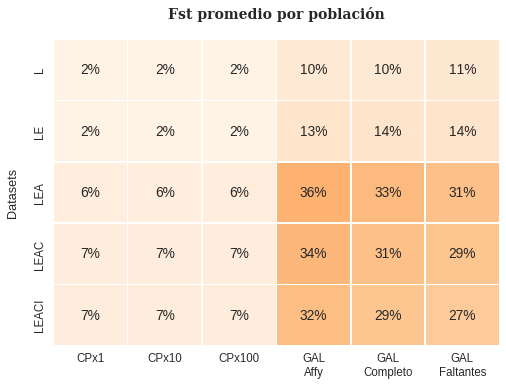

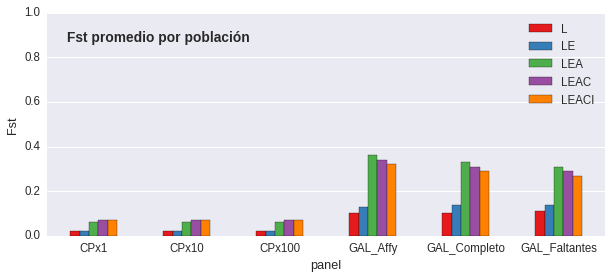

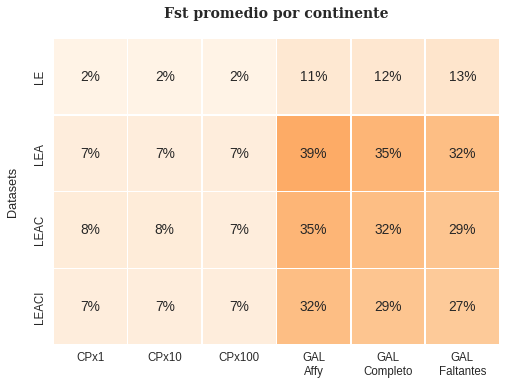

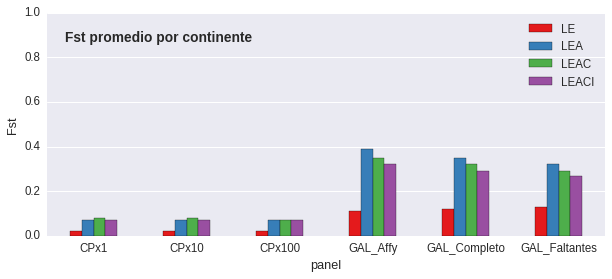

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.15)
sns.set_style("darkgrid")

trans = {"population": "población", "superpopulation": "continente"}

for level in mean_fst.index.get_level_values("pop_level").unique():
    df = mean_fst.loc[level]
    
    fig = plt.figure()
    palette = sns.color_palette("Blues")

    ax = sns.heatmap(df, annot=True, linewidths=.5, fmt=".0%",
                     vmax=1, vmin=0, cmap="Oranges", cbar=False)
    
    title = "Fst promedio por {}".format(trans[level])
    ax.set_title(title, y=1.05, family="serif", fontweight="bold", fontsize=14)

    fig = ax.get_figure()

    ax.set_ylabel("Datasets", labelpad=15)
    ax.set_xlabel("")
    xticklabels = ["\n".join(s.get_text().split("_")) for s in ax.get_xticklabels()]
    _ = ax.set_xticklabels(xticklabels,
                           rotation=0)
    plt.show()
    
    
    color = sns.color_palette("Set1", 5)
    ax = df.T.plot(kind="bar", figsize=(10, 4), rot=0, color=color)
    ax.set_title(title, y=0.85, x=0.2, fontweight="bold")
    ax.set_ylabel("Fst")
    ax.legend(fancybox=True)
    ax.set_ylim([0, 1])
    ax.xaxis.grid()
    plt.show()

# Safety check between my means and Plink ones in the .log files

In [5]:
%%bash

grep Mean ~/tesina/1000Genomes/fst_analysis/*.log | \
ruby -F: -lane 'puts [$F[0].gsub("/home/juan/tesina/1000Genomes/fst_analysis/", "").gsub(".", "\t"), $F.last].join("\t")' \
> ~/tesina/1000Genomes/fst_analysis/plink_fst_means

In [6]:
columns = ["dataset", "panel", "pop_level", "dropme", "FST"]
plink_fst_means = pd.read_table(join(WORKDIR, "plink_fst_means"), header=None, names=columns)
plink_fst_means.drop("dropme", inplace=True, axis=1)
plink_fst_means["FST"] = plink_fst_means["FST"].astype(float).map(lambda x: round(x, 2))
plink_fst_means = plink_fst_means.pivot_table(index=["pop_level", "dataset"],
                                              columns="panel", values="FST")
plink_fst_means - mean_fst

NameError: name 'means' is not defined